## **Mengimpor libaries**

In [1]:
# Mengimpor libaries pandas,numpy dan json untuk memproses data dalam format JSON
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## **Install mysql connector**

In [2]:
# install mysql connector
!pip install mysql-connector-python

In [3]:
# import libraries
import mysql.connector
from mysql.connector import Error

In [4]:
# Define MySQL details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = '3306'
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [5]:
# function to fetch data from database, the connection is closed after use.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        # use with to ensure the connection is closed after use
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params) # read the query to dataframe format
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

### **Query Data**

In [6]:
query = """

WITH order_garden_data AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        act.created_at,
        act.updated_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) AS old_status,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.created_at')) AS old_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.updated_at')) AS old_updated_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) AS attributes_status,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.created_at')) AS attributes_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.updated_at')) AS attributes_updated_at,
        TIMESTAMPDIFF(SECOND, 
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.created_at')),
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.attributes.updated_at')) 
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(SECOND,
            JSON_UNQUOTE(JSON_EXTRACT(properties, '$.old.updated_at')),
            act.created_at
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
        subject_type LIKE '%OrderDesign%' 
        OR subject_type LIKE '%OrderGarden%'
        OR subject_type LIKE '%OrderGardenCareDetail%'
        
),
build_start_attributes_status AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        act.created_at,
        dt.updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'acc_gardener'
        END AS old_status,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.created_at')) AS old_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.updated_at')) AS old_updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'build_start'
        END AS attributes_status,
        dt.created_at AS attributes_created_at,
        dt.updated_at AS attributes_updated_at,
        TIMESTAMPDIFF(
            SECOND, 
            dt.created_at,
            dt.updated_at
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(
            SECOND,
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.updated_at')),
            act.created_at
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
        (
            subject_type LIKE '%OrderDesign%' 
            OR subject_type LIKE '%OrderGarden%'
            OR subject_type LIKE '%OrderGardenCareDetail%'
        )
        AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener'
        AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
),
build_start_old_status AS (
    SELECT
        act.id,
        act.subject_type,
        act.subject_id,
        act.properties,
        dt.created_at,
        dt.updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'build_start' 
        END AS old_status,
        dt.created_at AS old_created_at,
        dt.datetime AS old_updated_at,
        CASE
            WHEN JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener' 
                 AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
            THEN 'in_review'
        END AS attributes_status,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.created_at')) AS attributes_created_at,
        JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.updated_at')) AS attributes_updated_at,
        TIMESTAMPDIFF(
            SECOND, 
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.created_at')),
            JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.updated_at'))
        ) / 3600 AS order_cycle_time,
        dt.id AS id_datetime,
        TIMESTAMPDIFF(
            SECOND,
            dt.created_at,
            dt.datetime
        ) / 3600 AS time_interval_status
    FROM
        activity_log act
    LEFT JOIN
        datetime dt ON act.subject_id = dt.datetimeable_id
    WHERE 
    (
        subject_type LIKE '%OrderDesign%' 
        OR subject_type LIKE '%OrderGarden%'
        OR subject_type LIKE '%OrderGardenCareDetail%'
    )
    AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.old.status')) = 'acc_gardener'
    AND JSON_UNQUOTE(JSON_EXTRACT(act.properties, '$.attributes.status')) = 'in_review'
)
SELECT * FROM (
SELECT * FROM order_garden_data
UNION ALL
SELECT * FROM build_start_attributes_status
UNION ALL
SELECT * FROM build_start_old_status) AS combined_data
ORDER BY id DESC;

"""
order_process = fetch_data(host, port, user, passwd, databs, query)

## **Explore Data**
Dalam proyek ini, kami menggunakan tabel **activity_log** untuk mengambil semua perubahan data order yang terjadi pada tiga tabel utama, yaitu:

1. OrderDesign
2. OrderGarden
3. OrderGardenCareDetail

In [7]:
# Menampilkan 5 baris pertama data.
order_process.head()

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925
3,16478,App\Models\OrderGardenCareDetail,976,"{""attributes"":{""id"":976,""id_order_garden_care""...",2024-11-14 22:24:25,2024-11-14 22:24:25,paid,2024-09-21T05:12:37.000000Z,2024-10-30T06:31:36.000000Z,acc_gardener,2024-09-21T05:12:37.000000Z,2024-11-14T15:24:25.000000Z,1306.1967,NaN,375.8803
4,16475,App\Models\OrderGardenCare,291,"{""attributes"":{""id"":291,""id_user"":1207,""id_gar...",2024-11-14 21:00:23,2024-11-14 21:00:23,on_going,2024-11-13T03:48:28.000000Z,2024-11-14T13:36:27.000000Z,in_review,2024-11-13T03:48:28.000000Z,2024-11-14T14:00:23.000000Z,34.1986,NaN,7.3989


In [8]:
order_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     1543 non-null   int64         
 1   subject_type           1543 non-null   object        
 2   subject_id             1543 non-null   int64         
 3   properties             1543 non-null   object        
 4   created_at             1492 non-null   datetime64[ns]
 5   updated_at             1441 non-null   datetime64[ns]
 6   old_status             1198 non-null   object        
 7   old_created_at         1147 non-null   object        
 8   old_updated_at         1147 non-null   object        
 9   attributes_status      1512 non-null   object        
 10  attributes_created_at  1472 non-null   object        
 11  attributes_updated_at  1472 non-null   object        
 12  order_cycle_time       1472 non-null   float64       
 13  id_

In [9]:
# Memfilter data berdasarkan subject_type
proses_subject_type = order_process[order_process['subject_type'].isin(['App\Models\OrderDesign','App\Models\OrderGarden','App\Models\OrderGardenCareDetail'])]

Dalam proyek ini, kami menggunakan hasil join tabel **activity_log** dan tabel **datetime** untuk mengambil semua perubahan data order yang terjadi pada tiga tabel utama, yaitu:

1. **OrderDesign**
2. **OrderGarden**
3. **OrderGardenCareDetail**

In [10]:
# Mengambil nilai unik dari kolom `subject_type`
proses_subject_type['subject_type'].unique()

array(['App\\Models\\OrderDesign', 'App\\Models\\OrderGardenCareDetail',
       'App\\Models\\OrderGarden'], dtype=object)

In [11]:
# Filter baris pada dataframe proses_subject_type yang memiliki perubahan status
# (yaitu atribut 'attributes_status' tidak sama dengan 'old_status')
proses_subject_type = proses_subject_type[proses_subject_type['attributes_status'] != proses_subject_type['old_status']]

In [12]:
# Hapus baris duplikat pada dataframe proses_subject_type berdasarkan kolom 'subject_id', 'old_status', dan 'attributes_status'
# Jaga hanya baris pertama dari setiap grup duplikat
proses_subject_type = proses_subject_type.drop_duplicates(subset=['subject_id','old_status','attributes_status'], keep='first')

In [13]:
proses_subject_type.shape

(861, 15)

## **Data Transformation**

##### Pada tahap ini, kami melakukan serangkaian transformasi data yang bertujuan untuk mempersiapkan dataset agar lebih siap untuk analisis mendalam.  
##### Transformasi ini mencakup dua aspek utama: pembuatan kolom baru dan pengubahan tipe data.

In [14]:
# Menampilkan 5 baris pertama data.
proses_subject_type.head()

,id,subject_type,subject_id,properties,created_at,updated_at,old_status,old_created_at,old_updated_at,attributes_status,attributes_created_at,attributes_updated_at,order_cycle_time,id_datetime,time_interval_status
0,16519,App\Models\OrderDesign,1018,"{""attributes"":{""id_order"":1018,""id_user"":1968,...",2024-11-15 08:47:27,2024-11-15 08:47:27,None,None,None,paid,2024-11-15T01:47:27.000000Z,2024-11-15T01:47:27.000000Z,0.0000,NaN,NaN
1,16515,App\Models\OrderDesign,1017,"{""attributes"":{""id_order"":1017,""id_user"":1967,...",2024-11-15 08:32:14,2024-11-15 08:32:14,None,None,None,paid,2024-11-15T01:32:14.000000Z,2024-11-15T01:32:14.000000Z,0.0000,NaN,NaN
2,16509,App\Models\OrderGardenCareDetail,1160,"{""attributes"":{""id"":1160,""id_order_garden_care...",2024-11-14 22:36:51,2024-11-14 22:36:51,paid,2024-10-06T10:18:37.000000Z,2024-11-02T03:55:18.000000Z,acc_gardener,2024-10-06T10:18:37.000000Z,2024-11-14T15:36:51.000000Z,941.3039,NaN,306.6925
3,16478,App\Models\OrderGardenCareDetail,976,"{""attributes"":{""id"":976,""id_order_garden_care""...",2024-11-14 22:24:25,2024-11-14 22:24:25,paid,2024-09-21T05:12:37.000000Z,2024-10-30T06:31:36.000000Z,acc_gardener,2024-09-21T05:12:37.000000Z,2024-11-14T15:24:25.000000Z,1306.1967,NaN,375.8803
5,16474,App\Models\OrderGardenCareDetail,1480,"{""attributes"":{""id"":1480,""id_order_garden_care...",2024-11-14 21:00:23,2024-11-14 21:00:23,acc_gardener,2024-11-13T03:48:29.000000Z,2024-11-14T13:36:27.000000Z,in_review,2024-11-13T03:48:29.000000Z,2024-11-14T14:00:23.000000Z,34.1983,NaN,7.3989


In [15]:
# Menampilkan 5 baris pertama data.
proses_subject_type.dtypes

id                                int64
subject_type                     object
subject_id                        int64
properties                       object
created_at               datetime64[ns]
updated_at               datetime64[ns]
old_status                       object
old_created_at                   object
old_updated_at                   object
attributes_status                object
attributes_created_at            object
attributes_updated_at            object
order_cycle_time                float64
id_datetime                     float64
time_interval_status            float64
dtype: object

In [16]:
# Mengonversi kolom 'old_created_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['old_created_at'] = pd.to_datetime(proses_subject_type['old_created_at'], errors='coerce')
proses_subject_type['old_created_at'] = pd.to_datetime(proses_subject_type['old_created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'old_updated_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['old_updated_at'] = pd.to_datetime(proses_subject_type['old_updated_at'], errors='coerce')
proses_subject_type['old_updated_at'] = pd.to_datetime(proses_subject_type['old_updated_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'attributes_created_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['attributes_created_at'] = pd.to_datetime(proses_subject_type['attributes_created_at'], errors='coerce')
proses_subject_type['attributes_created_at'] = pd.to_datetime(proses_subject_type['attributes_created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

# Mengonversi kolom 'attributes_updated_at' menjadi tipe datetime dan menghapus informasi zona waktu
proses_subject_type['attributes_updated_at'] = pd.to_datetime(proses_subject_type['attributes_updated_at'], errors='coerce')
proses_subject_type['attributes_updated_at'] = pd.to_datetime(proses_subject_type['attributes_updated_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize(None)

In [17]:
# Menampilkan 5 baris pertama data.
proses_subject_type.dtypes

id                                int64
subject_type                     object
subject_id                        int64
properties                       object
created_at               datetime64[ns]
updated_at               datetime64[ns]
old_status                       object
old_created_at           datetime64[ns]
old_updated_at           datetime64[ns]
attributes_status                object
attributes_created_at    datetime64[ns]
attributes_updated_at    datetime64[ns]
order_cycle_time                float64
id_datetime                     float64
time_interval_status            float64
dtype: object

##### Setelah dilakukan proses transformasi data, tipe data pada kolom `old_created_at`, `old_updated_at`, `attributes_created_at`, dan `attributes_updated_at` telah berhasil diubah dari tipe object menjadi tipe datetime. Perubahan ini memastikan bahwa data pada kolom-kolom tersebut lebih sesuai dengan konteksnya, yaitu merepresentasikan nilai waktu dan tanggal.

In [18]:
bott = proses_subject_type.copy()
bott['created_week'] = proses_subject_type['created_at'].dt.isocalendar().week

## **Analysis and Visualization**
Tahap "Analysis and Visualization" (Analisis dan Visualisasi) adalah langkah krusial dalam proses eksplorasi data. Dalam konteks ini, kita berfokus pada dua aspek utama: ringkasan **statistik (summary statistics)** dan **visualisasi data**

#### **Bottleneck Order Design Process**

In [19]:
# Filter data untuk OrderDesign
bott_design = bott[bott['subject_type'] == 'App\Models\OrderDesign']

# Menghitung rata-rata time_interval_status per created_week dan attributes_status
bott_design = (
    bott_design
    .groupby(['created_week', 'attributes_status'], as_index=False)['time_interval_status']
    .mean()
)

# Urutan status untuk sorting
status_order = ['new', 'paid', 'wait_freelancer', 'on_going', 'in_review_internal', 'in_review', 'finish', 'expired']

# Mengurutkan attributes_status sesuai urutan status_order
bott_design['attributes_status'] = pd.Categorical(bott_design['attributes_status'], categories=status_order, ordered=True)
bott_design = bott_design.sort_values(by=['created_week', 'attributes_status']).reset_index(drop=True)
bott_design['time_interval_status'] = bott_design['time_interval_status'].fillna(0)

bott_design['order_cycle_time_days'] = bott_design['time_interval_status'].div(24).round().astype(int).astype(str) + ' Hari'

# Menampilkan hasil akhir
bott_design


,created_week,attributes_status,time_interval_status,order_cycle_time_days
0,43,new,0.000000,0 Hari
1,43,paid,7.025750,0 Hari
2,43,wait_freelancer,20.491818,1 Hari
3,43,on_going,32.094345,1 Hari
4,43,in_review_internal,290.940395,12 Hari
5,43,in_review,56.584229,2 Hari
6,43,finish,7.009200,0 Hari
7,43,expired,55.018600,2 Hari
8,44,new,0.000000,0 Hari
9,44,paid,7.056580,0 Hari


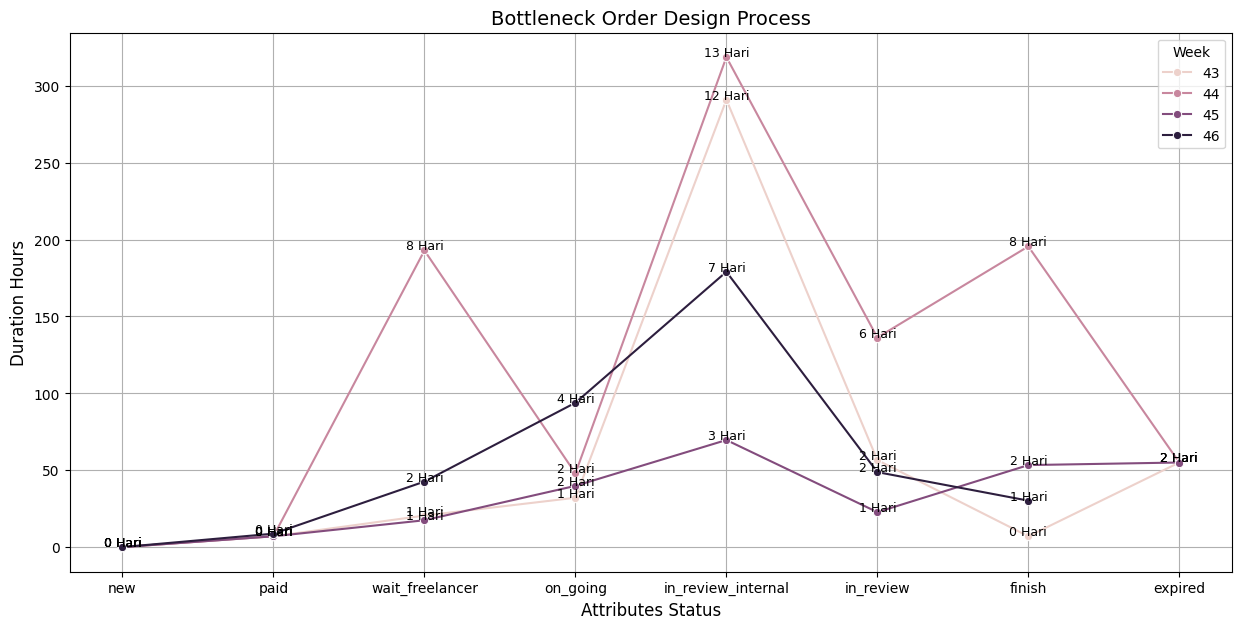

In [20]:
plt.figure(figsize=(15, 7))

# Menggunakan 'hue' untuk memisahkan garis berdasarkan 'created_week'
sns.lineplot(data=bott_design, x='attributes_status', y='time_interval_status', hue='created_week', marker='o', ci=None)

# Tambahkan label dari kolom 'order_cycle_time_days' di dekat setiap titik
for x, y, label in zip(bott_design['attributes_status'], bott_design['time_interval_status'], bott_design['order_cycle_time_days']):
    plt.text(x, y + 0.5, label, color='black', ha='center', fontsize=9)  # Sesuaikan offset y jika perlu

# Tambahkan judul dan label
plt.title('Bottleneck Order Design Process', fontsize=14)
plt.xlabel('Attributes Status', fontsize=12)
plt.ylabel('Duration Hours', fontsize=12)
plt.grid(True)

# Mengatur ticks pada sumbu X untuk hanya menampilkan nilai yang diinginkan
plt.xticks(bott_design['attributes_status'].unique())  # Hanya menampilkan ticks sesuai dengan 'attributes_status'
plt.legend(title='Week', fontsize=10)  # Menampilkan legend berdasarkan 'created_week'

# Tampilkan grafik
plt.show()

#### **Bottleneck Order Garden Process**

In [21]:
# Memfilter DataFrame berdasarkan subject_type
Bottleneck_Garden = bott[bott['subject_type'] == 'App\\Models\\OrderGarden']

# Mengelompokkan dan menghitung rata-rata atau median
Bottleneck_Garden = (
    Bottleneck_Garden.groupby(['created_week', 'attributes_status']).agg({
        'time_interval_status': 'mean',  # Ganti 'mean' dengan 'median' jika ingin menghitung median
    }).reset_index()
)

# Mengatur urutan untuk attributes_status
status_order = ['new', 'paid', 'wait_gardener', 'acc_gardener', 'in_review', 'finish', 'build_start', 'expired']

# Menambahkan kolom untuk urutan status
Bottleneck_Garden['status_order'] = Bottleneck_Garden['attributes_status'].apply(lambda x: status_order.index(x) if x in status_order else len(status_order))

# Mengurutkan DataFrame berdasarkan created_week dan status_order
Bottleneck_Garden = Bottleneck_Garden.sort_values(by=['created_week', 'status_order']).drop(columns=['status_order'])

# Pastikan ada cukup baris untuk dihapus
if len(Bottleneck_Garden) > 3:
    Bottleneck_Garden = Bottleneck_Garden.drop(index=[0, 1, 2]).reset_index(drop=True)

# Mengganti NaN dengan 0 atau nilai lain yang sesuai
Bottleneck_Garden['time_interval_status'] = Bottleneck_Garden['time_interval_status'].fillna(0)

# Menambahkan kolom order_cycle_time_days
Bottleneck_Garden['order_cycle_time_days'] = Bottleneck_Garden['time_interval_status'].apply(lambda x: f"{round(x / 24)} Hari")

# Menampilkan hasil
Bottleneck_Garden = Bottleneck_Garden.reset_index(drop=True)
Bottleneck_Garden

,created_week,attributes_status,time_interval_status,order_cycle_time_days
0,43,new,0.000000,0 Hari
1,43,paid,7.026700,0 Hari
2,43,wait_gardener,65.518100,3 Hari
3,43,acc_gardener,7.003600,0 Hari
4,43,in_review,218.063300,9 Hari
5,43,build_start,242.305100,10 Hari
6,44,new,0.000000,0 Hari
7,44,paid,7.095300,0 Hari
8,44,wait_gardener,53.089915,2 Hari
9,44,in_review,37.613273,2 Hari


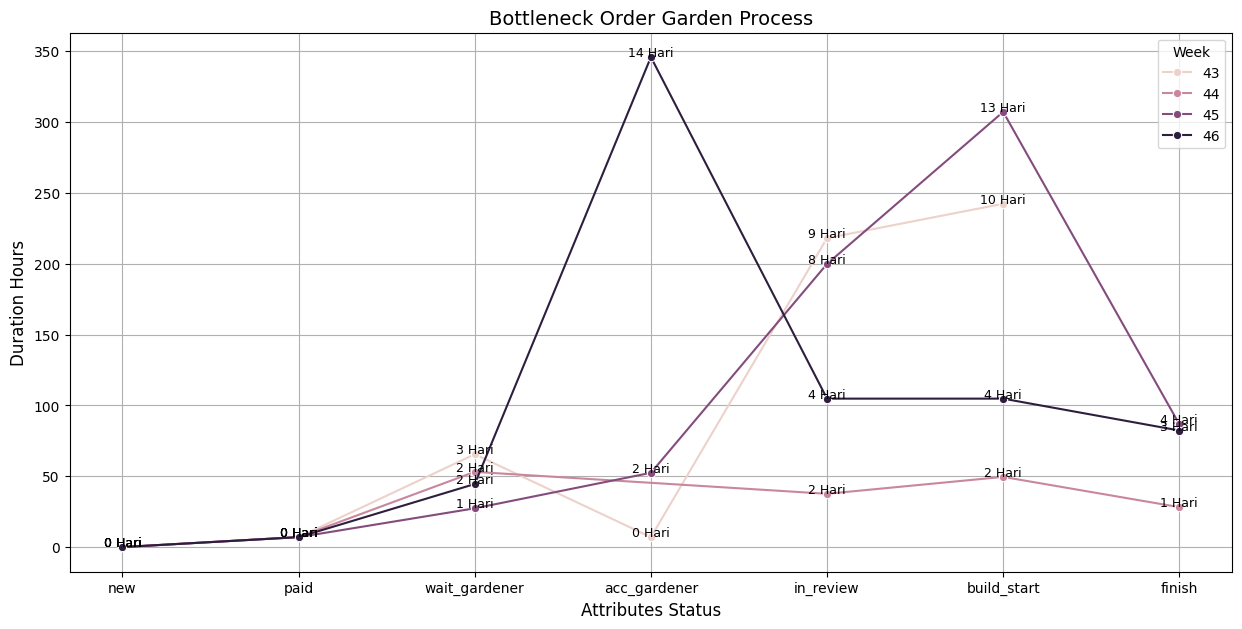

In [22]:
plt.figure(figsize=(15, 7))

# Menggunakan 'hue' untuk memisahkan garis berdasarkan 'created_week'
sns.lineplot(data=Bottleneck_Garden, x='attributes_status', y='time_interval_status', hue='created_week', marker='o', ci=None)

# Tambahkan label dari kolom 'order_cycle_time_days' di dekat setiap titik
for x, y, label in zip(Bottleneck_Garden['attributes_status'], Bottleneck_Garden['time_interval_status'], Bottleneck_Garden['order_cycle_time_days']):
    plt.text(x, y + 0.5, label, color='black', ha='center', fontsize=9)  # Sesuaikan offset y jika perlu

# Tambahkan judul dan label
plt.title('Bottleneck Order Garden Process', fontsize=14)
plt.xlabel('Attributes Status', fontsize=12)
plt.ylabel('Duration Hours', fontsize=12)
plt.grid(True)

# Mengatur ticks pada sumbu X untuk hanya menampilkan nilai yang diinginkan
plt.xticks(Bottleneck_Garden['attributes_status'].unique())  # Hanya menampilkan ticks sesuai dengan 'attributes_status'
plt.legend(title='Week', fontsize=10)  # Menampilkan legend berdasarkan 'created_week'

# Tampilkan grafik
plt.show()

#### **Bottleneck Order Garden Care Detail Process**

In [23]:
Bottleneck_Care = bott[bott['subject_type'] == 'App\\Models\\OrderGardenCareDetail']

# Mengelompokkan dan menghitung rata-rata atau median
Bottleneck_Care = (
    Bottleneck_Care.groupby(['created_week', 'attributes_status']).agg({
        'time_interval_status': 'mean',  # Ganti 'mean' dengan 'median' jika ingin menghitung median
    }).reset_index()
)

# Mengganti NaN dengan 0 atau nilai lain yang sesuai
Bottleneck_Care['time_interval_status'] = Bottleneck_Care['time_interval_status'].fillna(0)

# Menambahkan kolom order_cycle_time_days
Bottleneck_Care['order_cycle_time_days'] = Bottleneck_Care['time_interval_status'].apply(lambda x: f"{round(x / 24)} Hari")

# Mengatur urutan untuk attributes_status
status_order = ['paid', 'acc_gardener', 'in_review']

# Menambahkan kolom untuk urutan status
Bottleneck_Care['status_order'] = Bottleneck_Care['attributes_status'].apply(lambda x: status_order.index(x) if x in status_order else len(status_order))

# Mengurutkan DataFrame berdasarkan created_week dan status_order
Bottleneck_Care = Bottleneck_Care.sort_values(by=['created_week', 'status_order']).drop(columns=['status_order'])

# Menghapus baris dengan attributes_status tertentu
Bottleneck_Care = Bottleneck_Care[~Bottleneck_Care['attributes_status'].isin(['build_start', 'new'])].reset_index(drop=True)

# Pastikan ada cukup baris untuk dihapus
if len(Bottleneck_Care) > 0:
    Bottleneck_Care = Bottleneck_Care.drop(index=[0]).reset_index(drop=True)

# Menampilkan hasil
Bottleneck_Care


,created_week,attributes_status,time_interval_status,order_cycle_time_days
0,43,paid,1282.921500,53 Hari
1,43,acc_gardener,415.786268,17 Hari
2,43,in_review,73.304306,3 Hari
3,44,paid,970.688050,40 Hari
4,44,acc_gardener,608.770090,25 Hari
5,44,in_review,132.878818,6 Hari
6,45,paid,557.940112,23 Hari
7,45,acc_gardener,430.107902,18 Hari
8,45,in_review,153.252100,6 Hari
9,46,paid,276.134600,12 Hari


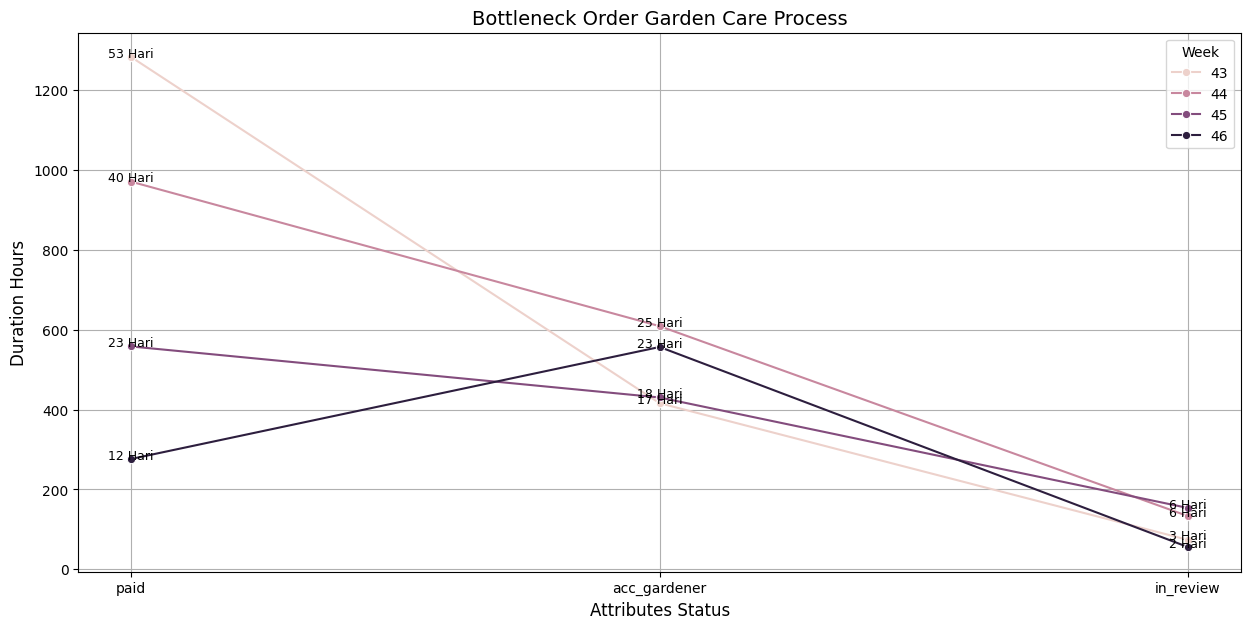

In [24]:
plt.figure(figsize=(15, 7))

# Menggunakan 'hue' untuk memisahkan garis berdasarkan 'created_week'
sns.lineplot(data=Bottleneck_Care, x='attributes_status', y='time_interval_status', hue='created_week', marker='o', ci=None)

# Tambahkan label dari kolom 'order_cycle_time_days' di dekat setiap titik
for x, y, label in zip(Bottleneck_Care['attributes_status'], Bottleneck_Care['time_interval_status'], Bottleneck_Care['order_cycle_time_days']):
    plt.text(x, y + 0.5, label, color='black', ha='center', fontsize=9)  # Sesuaikan offset y jika perlu

# Tambahkan judul dan label
plt.title('Bottleneck Order Garden Care Process', fontsize=14)
plt.xlabel('Attributes Status', fontsize=12)
plt.ylabel('Duration Hours', fontsize=12)
plt.grid(True)

# Mengatur ticks pada sumbu X untuk hanya menampilkan nilai yang diinginkan
plt.xticks(Bottleneck_Care['attributes_status'].unique())  # Hanya menampilkan ticks sesuai dengan 'attributes_status'
plt.legend(title='Week', fontsize=10)  # Menampilkan legend berdasarkan 'created_week'

# Tampilkan grafik
plt.show()